Epoch     10. Loss 1.3584108
Epoch     20. Loss 1.3382823
Epoch     30. Loss 1.3129829
Epoch     40. Loss 1.3160102
Epoch     50. Loss 1.3110673
Epoch     60. Loss 1.3045661
Epoch     70. Loss 1.2972343
Epoch     80. Loss 1.2886872
Epoch     90. Loss 1.2767177
Epoch    100. Loss 1.2388985
Epoch    110. Loss 1.2778683
Epoch    120. Loss 1.2416024
Epoch    130. Loss 1.2462189
Epoch    140. Loss 1.2650495
Epoch    150. Loss 1.2301220
Epoch    160. Loss 1.2440337
Epoch    170. Loss 1.2374959
Epoch    180. Loss 1.2354177
Epoch    190. Loss 1.2187889
Epoch    200. Loss 1.1989360
Epoch    210. Loss 1.2532579
Epoch    220. Loss 1.2279849
Epoch    230. Loss 1.2207649
Epoch    240. Loss 1.2166475
Epoch    250. Loss 1.2223811
Epoch    260. Loss 1.1923926
Epoch    270. Loss 1.2282181
Epoch    280. Loss 1.1847746
Epoch    290. Loss 1.1828580
Epoch    300. Loss 1.2298740
Epoch    310. Loss 1.2302434
Epoch    320. Loss 1.2426608
Epoch    330. Loss 1.2022533
Epoch    340. Loss 1.1983573
Epoch    350. 

Text(0.5, 1.0, 'Estimated vs True')

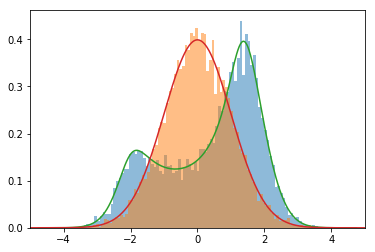

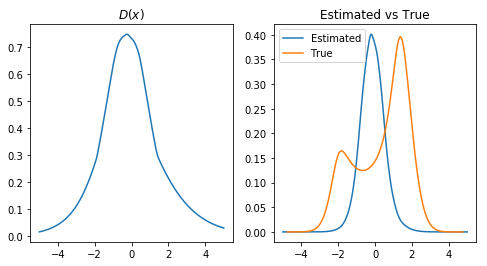

In [1]:
import torch
import simpleclassdef as classdef
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import samplers
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Descr():
    def __init__(self, hidden_size, mini_batch, learning_rate, num_epochs, print_interval):
        super(Descr, self).__init__()
        self.input_size = 1    
        self.hidden_size = hidden_size
        self.output_size = 1
        self.minibatch_size = mini_batch
        self.learning_rate = learning_rate        
        self.num_epochs = num_epochs
        self.print_interval = print_interval
        self.Network = classdef.MLP_Network(self.input_size, self.hidden_size, self.output_size)
        self.Network.to(device)
        self.optimizer = optim.Adam(self.Network.parameters(), lr=self.learning_rate)
        
    def loss_function(self, x, y):
        loss_fun = -((torch.mean(torch.log(x)) + torch.mean(torch.log(1.0 - y))))
        return loss_fun
    
    def run_main_loop(self, p_distribution, q_distribution):
        self.Network.train()
        for epoch in range(self.num_epochs):            
            self.optimizer.zero_grad()            
            p_iterator = iter(p_distribution)
            q_iterator = iter(q_distribution)
            px = next(p_iterator)
            qx = next(q_iterator)
            p_tensor = Variable( torch.from_numpy(np.float32(px.reshape(self.minibatch_size, self.input_size)))).to(device)
            q_tensor = Variable( torch.from_numpy(np.float32(qx.reshape(self.minibatch_size, self.input_size)))).to(device)
            D_x = self.Network(p_tensor)
            D_y = self.Network(q_tensor)
            loss_variable = self.loss_function(D_x, D_y)
            loss_variable.backward()
            self.optimizer.step()
            if( epoch % self.print_interval) == (self.print_interval-1):
                print( "Epoch %6d. Loss %5.7f" % ( epoch+1, loss_variable.item()))

#From density_estimation.py

# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,512)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))

############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######
f0 = samplers.GaussianDistribution()
f1 = samplers.distribution4()

Descr_M = Descr(hidden_size=512, mini_batch=512, learning_rate=0.0001, num_epochs=1000, print_interval=10)
Descr_M.run_main_loop(f0, f1)

random_input_tensor = Variable( torch.from_numpy(np.float32(xx.reshape(Descr_M.minibatch_size, Descr_M.input_size))))
Network_Output = Descr_M.Network(random_input_tensor)
f1_estimated = Network_Output / (1 - Network_Output) * N(random_input_tensor) 

############### plotting things
############### (1) plot the output of your trained discriminator 
############### (2) plot the estimated density contrasted with the true density



r = Network_Output.detach().numpy() # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

f1_est = f1_estimated.detach().numpy()
estimate = f1_est*0.35 # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')